# TWAP Analysis

## Purpose
Explore Reflexer RAI/USD Oracle TWAP

In [1]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200 

In [3]:
# Number of most recent minutes to display for all plots
N_PLOTS = 10000

## Load Data

#### Chainlink RAI/USD feed data

In [4]:
df_cl = pd.read_csv('cl_rai_usd.csv')
df_cl = df_cl.rename(columns={"RAI / USD": "rai_usd_link", "Answer": "time"})
df_cl['time'] = pd.to_datetime(df_cl['time'], infer_datetime_format=True, utc=True)
df_cl['time_1m'] = df_cl['time'].dt.round('1min') 
df_cl = df_cl.drop_duplicates(['time_1m']) 
df_cl = df_cl.set_index('time_1m')
df_cl = df_cl.asfreq('1min', method='ffill')

In [5]:
df_cl.tail(3)

,time,rai_usd_link
time_1m,,
2021-11-03 03:58:00+00:00,2021-11-02 16:00:00+00:00,3.030000
2021-11-03 03:59:00+00:00,2021-11-02 16:00:00+00:00,3.030000
2021-11-03 04:00:00+00:00,2021-11-03 04:00:00+00:00,3.031595


#### Chainlink ETH/USD data

In [6]:
df_link = pd.read_csv('link_eth.csv.gz')
df_link = df_link.rename(columns={"price": "eth_usd_link", "ts": "time"}).drop(["started_at"], axis=1)
df_link['eth_usd_link'] /= 1E8
df_link['time'] = pd.to_datetime(df_link['time'], unit='s', utc=True)
df_link['time_1m'] = df_link['time'].dt.round('1min') 
df_link = df_link.drop_duplicates(['time_1m']) 
df_link = df_link.set_index('time_1m')
df_link = df_link.asfreq('1min', method='ffill')

#### Chainlink Relayer ETH/USD data

In [7]:
df_relay = pd.read_csv('prod_relayer.csv')
df_relay = df_relay.rename(columns={"ts": "time"})
df_relay['eth_usd'] = (df_relay['eth_usd'].astype(float) / 1E18).astype(int)
df_relay['time'] = pd.to_datetime(df_relay['time'], unit='s', utc=True)
df_relay['time_1m'] = df_relay['time'].dt.round('1min') 
df_relay = df_relay.drop_duplicates(['time_1m']) 
df_relay = df_relay.set_index('time_1m')
df_relay = df_relay.asfreq('1min', method='ffill')

In [8]:
#df_link[(df_link['block'] > 13450000) & (df_link['block'] < 13450200)].head(30)

#### Prod RAI/USD TWAP data

In [9]:
# Prod RAI/USD TWAP
# RAI/USD values derived from RAI/ETH TWAP and TWAP of Chainlink spot ETH/USD. 
# Time: modified time
# Source: the graph systemState.
df_twap = pd.read_csv('twap.csv')
df_twap = df_twap.rename(columns={"value": "twap_usd"})

# Eliminate repeat duplicates. 
# This keeps first update so we can join with the CL ETH/USD price at the time of update
df_twap['prev_twap_usd'] = df_twap['twap_usd'].shift()
df_twap = df_twap[df_twap['prev_twap_usd'] != df_twap['twap_usd']].drop('prev_twap_usd', axis=1)
df_twap['time'] = pd.to_datetime(df_twap['time'], infer_datetime_format=True, utc=True)
df_twap['time_1m'] = df_twap['time'].dt.round('1min') 
df_twap = df_twap.drop_duplicates(['time_1m']) 
df_twap = df_twap.set_index('time_1m')

# Don't fill twap. Retain original update times to match with chainlink eth/usd
#df_twap = df_twap.asfreq('1min', method='ffill')

In [10]:
#df_twap_trim = df_twap[(df_twap.index > pd.to_datetime('2021-10-18').tz_localize('utc')) & (df_twap.index < pd.to_datetime('2021-10-21').tz_localize('utc'))]

In [11]:
#df_twap_trim.head(10)

In [12]:
#df_link_trim = df_link[(df_link.index > pd.to_datetime('2021-10-18').tz_localize('utc')) & (df_link.index < pd.to_datetime('2021-10-21').tz_localize('utc'))]
#df_link_trim.head(10)

#### RAI/ETH Uniswap v2 data

In [13]:
# Spot RAI/ETH. 
# Time: modified time
# Source: The graph uniswapPair


"""
df_rai = pd.read_csv('rai_eth.csv')
df_rai = df_rai.rename(columns={"value": "rai_eth"})
df_rai['time'] = pd.to_datetime(df_rai['time'], infer_datetime_format=True, utc=True)
df_rai['time_1m'] = df_rai['time'].dt.round('1min') 
df_rai = df_rai.drop_duplicates(['time_1m']) 
df_rai = df_rai.set_index('time_1m')
df_rai = df_rai.asfreq('1min', method='ffill')

"""

# Spot RAI/ETH
# time: blocktime
# Source: onchain
df_rai = pd.read_csv('rai_eth_new.csv')
df_rai['time'] = pd.to_datetime(df_rai['time'], unit='s', utc=True)
df_rai['time_1m'] = df_rai['time'].dt.round('1min') 
df_rai = df_rai.drop_duplicates(['time_1m']) 
df_rai = df_rai.set_index('time_1m')
df_rai = df_rai.asfreq('1min', method='ffill')

In [14]:
# Create RAI/ETH cumulativePrice
df_rai_cum = pd.read_csv('rai_eth_new.csv')
df_rai_cum['time'] = pd.to_datetime(df_rai['time'], unit='s', utc=True)
df_rai_cum['time_diff'] = df_rai_cum['time'].diff()
df_rai_cum['rai_eth_prod'] = df_rai_cum['rai_eth'] * df_rai_cum['time_diff']


In [15]:
df_rai.tail(3)

,block_number,time,rai_eth
time_1m,,,
2021-11-04 11:43:00+00:00,13549993,2021-11-04 11:40:03+00:00,0.000675
2021-11-04 11:44:00+00:00,13549993,2021-11-04 11:40:03+00:00,0.000675
2021-11-04 11:45:00+00:00,13550016,2021-11-04 11:45:12+00:00,0.000674


#### ETH/USD Coingecko data

In [16]:
# Spot ETH/USD from Coingecko. 
# Time: API query time
df_eth = pd.read_csv('eth_usd.csv')
df_eth = df_eth.rename(columns={"value": "eth_usd_spot"})
df_eth['time'] = pd.to_datetime(df_eth['time'], infer_datetime_format=True, utc=True)
df_eth['time_1m'] = df_eth['time'].dt.round('1min') 
df_eth = df_eth.drop_duplicates(['time_1m']) 
df_eth = df_eth.set_index('time_1m')
df_eth = df_eth.asfreq('1min', method='ffill')

In [17]:
df_eth.tail(2)

,time,eth_usd_spot,field
time_1m,,,
2021-10-26 14:20:00+00:00,2021-10-26 14:19:07+00:00,4170.09,ETH/USD price
2021-10-26 14:21:00+00:00,2021-10-26 14:21:11+00:00,4169.00,ETH/USD price


#### New TWAP data

In [18]:
# New TWAP values
df_new_twap = pd.read_csv('new_twap.csv')
df_new_twap = df_new_twap.rename(columns={"price": "rai_usd", "ts": "time"})
df_new_twap['rai_usd'] /= 1E18
df_new_twap['time'] = pd.to_datetime(df_new_twap['time'], unit='s', utc=True)
df_new_twap['time_1m'] = df_new_twap['time'].dt.round('1min') 
df_new_twap = df_new_twap.drop_duplicates(['time_1m']) 
df_new_twap = df_new_twap.set_index('time_1m')
df_new_twap = df_new_twap.asfreq('1min', method='ffill')

In [19]:
df_new_twap.tail(3)

,block,rai_usd,time
time_1m,,,
2021-11-03 16:41:00+00:00,13544979,3.033485,2021-11-03 16:40:36+00:00
2021-11-03 16:42:00+00:00,13544981,3.033485,2021-11-03 16:41:40+00:00
2021-11-03 16:43:00+00:00,13544988,3.033485,2021-11-03 16:42:33+00:00


#### Join all dataframes

In [20]:
df_rai_eth = pd.merge(df_rai['rai_eth'], df_eth['eth_usd_spot'], left_index=True, right_index=True)
df_rai_eth_link = pd.merge(df_rai_eth[['rai_eth', 'eth_usd_spot']], df_link['eth_usd_link'], left_index=True, right_index=True)
df = pd.merge(df_rai_eth_link[['rai_eth', 'eth_usd_spot', 'eth_usd_link']], df_twap['twap_usd'], left_index=True, right_index=True)
#df = pd.merge(df[['rai_eth', 'eth_usd_spot', 'eth_usd_link', 'twap_usd']], df_cl['rai_usd_link'], left_index=True, right_index=True)

#### Calculate spot RAI/USD from spot RAI/ETH and spot ETH/USD

In [21]:
df['rai_usd'] = df['rai_eth'] * df['eth_usd_link']

In [22]:
len(df)

860

In [23]:
df_trim = df[(df.index > pd.to_datetime('2021-10-18').tz_localize('utc')) & (df.index < pd.to_datetime('2021-10-21').tz_localize('utc'))]#

In [64]:
def create_prod_twap(rai_eth, prod_twap, eth_usd,  window_size, period_size, eth_usd_col='eth_usd', fill=False):
    """
    Parameters
    ----------
    rai_eth: 1m rai_eth
    prod_twap: twap values only at time of update
    eth_usd: 1m chainlink eth_usd
    
    """
   
    df_rai['rai_eth_mean'] = rai_eth.rolling(str(window_size+0.666) + 'H').mean()

    df_twap_link = pd.merge(prod_twap, eth_usd, left_index=True, right_index=True)

    df_twap_link[eth_usd_col + '_mean'] = df_twap_link.rolling(str(window_size) + 'H')[eth_usd_col].mean()

    df_r = pd.merge(df_rai['rai_eth_mean'], df_twap_link[eth_usd_col + '_mean'], left_index=True, right_index=True)
    df_r['twap_usd_r'] = df_r['rai_eth_mean'] * df_twap_link[eth_usd_col + '_mean']
    
    if not fill:
        return df_r
    
    return df_r.asfreq('1min', method='ffill')

def create_prod_twap2(rai_eth, prod_twap, eth_usd, window_size, period_size, eth_usd_col='eth_usd', fill=False):
    """
    Parameters
    ----------
    rai_eth: 1m rai/eth
    prod_twap: twap values only at time of update
    eth_usd: 1m chainlink eth_usd
    
    """
    # for each twap update in `prod_twap`
    #     get rai/eth mean since first rai/eth obs-
    #     get eth/usd mean since first eth/usd obs
    #
    #
    #
    rai_eth_mean = rai_eth.rolling(str(window_size+0.666) + 'H').mean()

    df_twap_link = pd.merge(prod_twap, eth_usd, left_index=True, right_index=True)
    
    df_twap_link['time'] = df_twap_link.index.values
    
    df_twap_link['time_diff'] = df_twap_link['time'].diff().dt.total_seconds()
    
    df_twap_link['eth_usd_time_adj'] =  df_twap_link[eth_usd_col] * df_twap_link['time_diff']

    #df_twap_link = df_twap_link.dropna()
    
    df_twap_link['eth_usd_cum'] = df_twap_link['eth_usd_time_adj'].rolling(period_size).sum()
    
    df_twap_link['sec_since_first'] = (df_twap_link['time'] - df_twap_link['time'].shift(period_size)).dt.total_seconds()
    
    #df_twap_link = df_twap_link.dropna()
    
    print(df_twap_link[df_twap_link['sec_since_first'] > 26 * 3600])
    
    df_twap_link[eth_usd_col + '_mean'] = df_twap_link['eth_usd_cum']/df_twap_link['sec_since_first']

    df_r = pd.merge(rai_eth_mean, df_twap_link[eth_usd_col + '_mean'], left_index=True, right_index=True)
    df_r.info()
    df_r['twap_usd_r'] = df_r['rai_eth'] * df_twap_link[eth_usd_col + '_mean']
    
    if not fill:
        return df_r
    
    return df_r.asfreq('1min', method='ffill')

def create_prod_twap3(rai_eth, prod_twap, eth_usd, window_size, period_size, eth_usd_col='eth_usd', fill=False):
    """
    Parameters
    ----------
    rai_eth: 1m rai/eth
    prod_twap: twap values only at time of update
    eth_usd: 1m chainlink eth_usd
    
    """
    assert window_size % period_size == 0
    
    granularity = int(window_size / period_size)
    # for each twap update in `prod_twap`
    #     get rai/eth mean since first rai/eth obs-
    #     get eth/usd mean since first eth/usd obs
    #
    #
    #
    rai_eth_mean = rai_eth.rolling(str(window_size+0.666) + 'H').mean()

    df_twap_link = pd.merge(prod_twap, eth_usd, left_index=True, right_index=True)
    
    df_twap_link['time'] = df_twap_link.index.values
    
    df_twap_link['time_diff'] = df_twap_link['time'].diff().dt.total_seconds()
    
    df_twap_link['eth_usd_time_adj'] =  df_twap_link[eth_usd_col] * df_twap_link['time_diff']
    
    df_twap_link['eth_usd_cum'] = df_twap_link['eth_usd_time_adj'].rolling(granularity).sum()
    
    df_twap_link['sec_since_first'] = (df_twap_link['time'] - df_twap_link['time'].shift(granularity)).dt.total_seconds()
    
    
    #print(df_twap_link[df_twap_link['sec_since_first'] > 26 * 3600])
    
    df_twap_link[eth_usd_col + '_mean'] = df_twap_link['eth_usd_cum']/df_twap_link['sec_since_first']

    df_r = pd.merge(rai_eth_mean, df_twap_link[eth_usd_col + '_mean'], left_index=True, right_index=True)
    #df_r.info()
    
    # covariance with granularity samples
    #df_cov = pd.merge(rai_eth, df_twap_link, left_index=True, right_index=True)   
    #df_cov['cov'] = df_cov['rai_eth'].rolling(granularity).cov(df_cov[eth_usd_col])
    
    # covariance over all values in window
    df_cov = pd.merge(rai_eth, eth_usd, left_index=True, right_index=True) 
    df_cov['cov'] = df_cov['rai_eth'].rolling(str(window_size+0.666) + 'H').cov(df_cov[eth_usd_col])
    
    df_r['twap_usd_r'] = df_r['rai_eth'] * df_twap_link[eth_usd_col + '_mean'] + df_cov['cov']
    
    if not fill:
        return df_r
    
    return df_r.asfreq('1min', method='ffill')

In [67]:
len(df_rai['rai_eth']), len(df_twap['twap_usd']), len(df_link['eth_usd_link'])

(235483, 860, 27266003)

In [65]:
df_r = create_prod_twap(df_rai['rai_eth'], df_twap['twap_usd'], df_link['eth_usd_link'], window_size=16, period_size=4, eth_usd_col='eth_usd_link')
df_r2 = create_prod_twap2(df_rai['rai_eth'], df_twap['twap_usd'], df_link['eth_usd_link'], window_size=16, period_size=4, eth_usd_col='eth_usd_link')
df_r3 = create_prod_twap3(df_rai['rai_eth'], df_twap['twap_usd'], df_link['eth_usd_link'], window_size=16, period_size=4, eth_usd_col='eth_usd_link')

#df_r_b = create_prod_twap(df_rai['rai_eth'], df_twap['twap_usd'], df_relay['eth_usd'], window_size=16, period_size=4, eth_usd_col='eth_usd')
#df_r2_b = create_prod_twap2(df_rai['rai_eth'], df_twap['twap_usd'], df_relay['eth_usd'], window_size=16, period_size=4, eth_usd_col='eth_usd')

                           twap_usd  eth_usd_link                time  \
time_1m                                                                 
2021-06-27 10:53:00+00:00  3.018964   1825.670000 2021-06-27 10:53:00   
2021-08-05 11:58:00+00:00  3.004794   2621.500000 2021-08-05 11:58:00   
2021-08-05 16:08:00+00:00  3.024088   2770.117656 2021-08-05 16:08:00   
2021-08-05 20:18:00+00:00  3.024545   2793.786919 2021-08-05 20:18:00   
2021-08-06 00:30:00+00:00  3.034377   2825.840000 2021-08-06 00:30:00   

                           time_diff  eth_usd_time_adj   eth_usd_cum  \
time_1m                                                                
2021-06-27 10:53:00+00:00    48900.0      8.927526e+07  1.686231e+08   
2021-08-05 11:58:00+00:00   149700.0      3.924386e+08  5.054435e+08   
2021-08-05 16:08:00+00:00    15000.0      4.155176e+07  5.096028e+08   
2021-08-05 20:18:00+00:00    15000.0      4.190680e+07  5.135446e+08   
2021-08-06 00:30:00+00:00    15120.0      4.272670e+07  

In [32]:
#df['twap_usd'].tail(100)

In [33]:
#df_trim = pd.merge(df, df_r2['twap_usd_r'], left_index=True, right_index=True)

In [34]:
#df_trim.head(20)

In [53]:
df_fill = df.asfreq('1min', method='ffill')
df_fill.tail(10)

,rai_eth,eth_usd_spot,eth_usd_link,twap_usd,rai_usd
time_1m,,,,,
2021-10-26 13:39:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:40:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:41:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:42:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:43:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:44:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:45:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:46:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316
2021-10-26 13:47:00+00:00,0.00072,4221.44,4219.429916,3.035265,3.037316


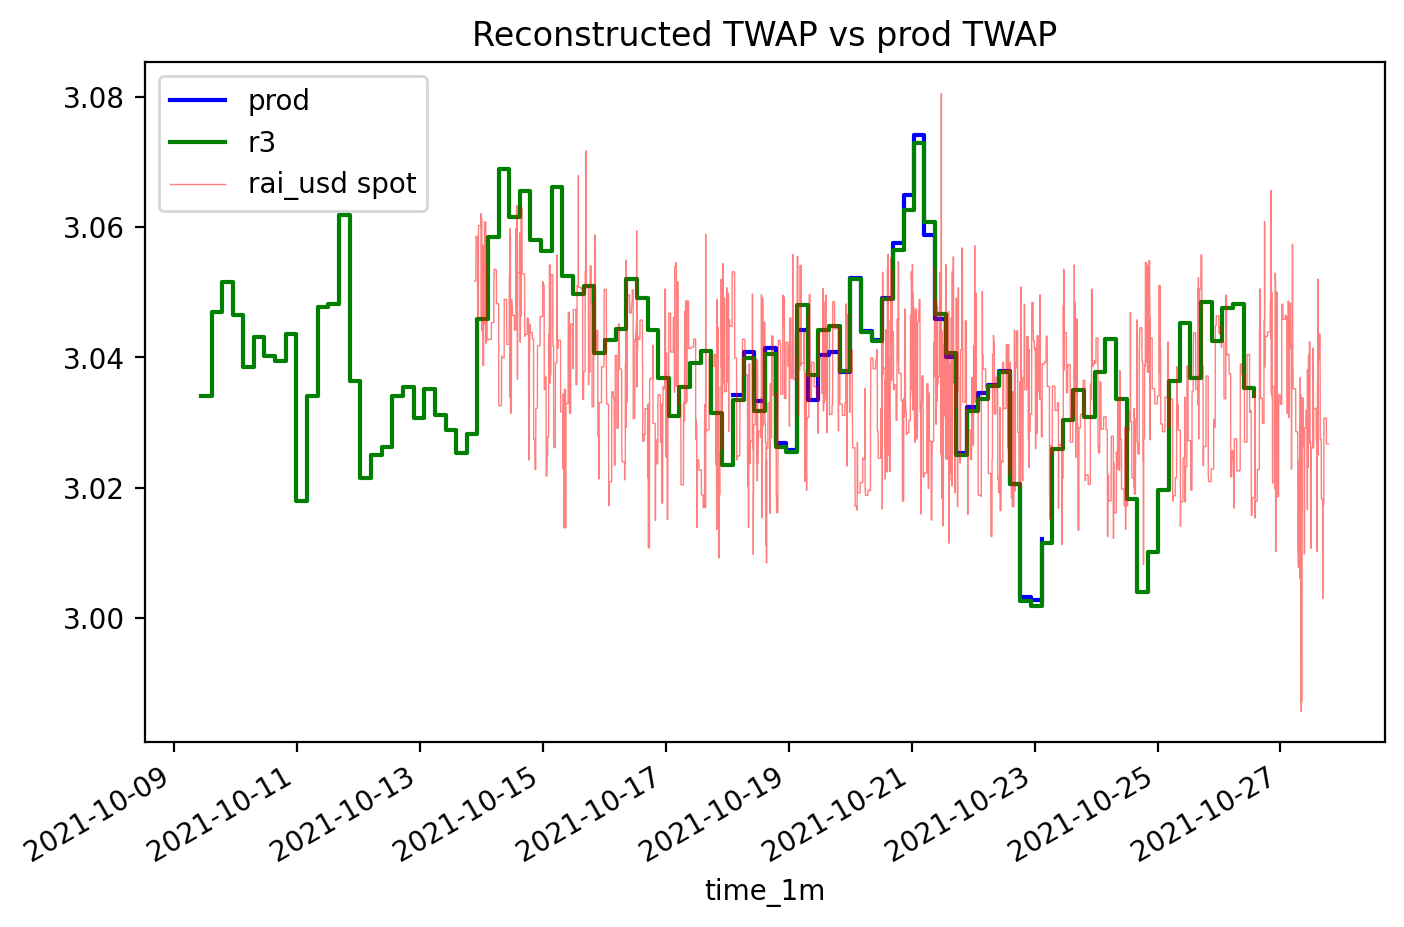

In [66]:
ax = df['twap_usd'][-50:-20].plot(color='blue', label='prod', drawstyle='steps-post')

#df_r['twap_usd_r'][-100:].plot(ax=ax, color='blue', label='r', drawstyle='steps-post')
df_r3['twap_usd_r'][-100:].plot(ax=ax, color='green', label='r3', drawstyle='steps-post')
#df_fill['rai_usd'][-8000:].plot(ax=ax, color='red', label='spot')
rai_link['rai_usd'][-30000:-10000].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)

#df_r2_b['twap_usd_r'][-50:-20].plot(ax=ax, color='red', label='r2', drawstyle='steps-post')
#df_r_b['twap_usd_r'][-100:].plot(ax=ax, color='blue', label='r', drawstyle='steps-post')


plt.title('Reconstructed TWAP vs prod TWAP')
plt.legend()

# Prod RAI/USD TWAP vs RAI/USD spot

In [55]:
# Create spot RAI/USD from spot RAI/ETH and Chainlink ETH/USD
rai_link= pd.merge(df_rai['rai_eth'], df_link['eth_usd_link'], left_index=True, right_index=True)
rai_link['rai_usd'] = rai_link['rai_eth'] * rai_link['eth_usd_link']

In [56]:
df_fill = df.asfreq('1min', method='ffill')

In [57]:
rai_link.tail(5)

,rai_eth,eth_usd_link,rai_usd
time_1m,,,
2021-11-03 17:18:00+00:00,0.000669,4518.161959,3.023263
2021-11-03 17:19:00+00:00,0.000669,4518.161959,3.023263
2021-11-03 17:20:00+00:00,0.000669,4518.161959,3.023263
2021-11-03 17:21:00+00:00,0.000669,4518.161959,3.023263
2021-11-03 17:22:00+00:00,0.000669,4541.040000,3.038572


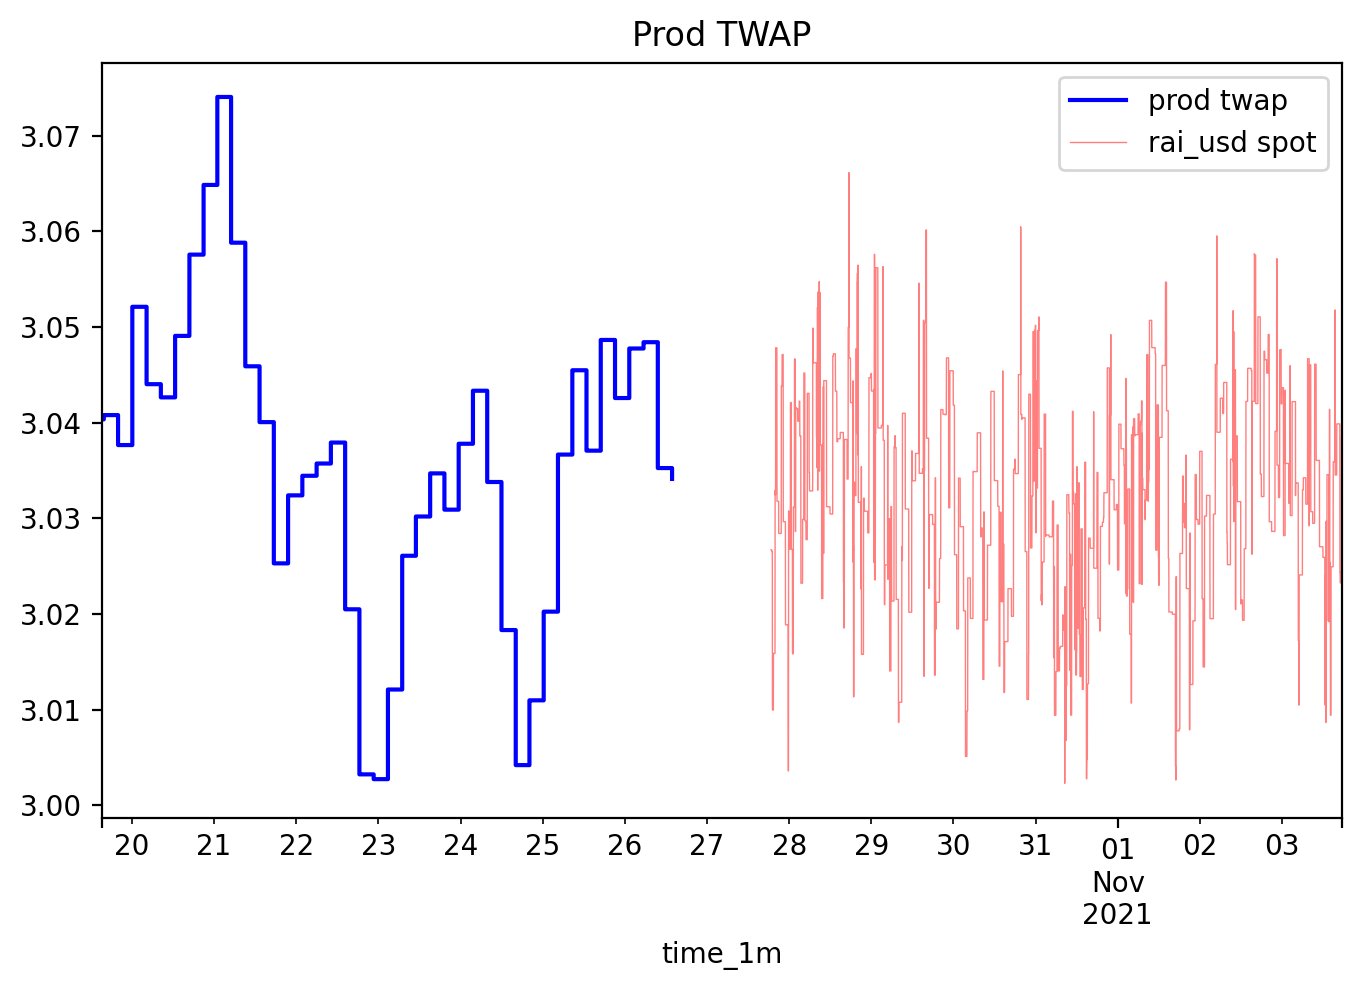

In [58]:
ax = df_fill['twap_usd'][-N_PLOTS:].plot(color='blue', label='prod twap', drawstyle="steps-post")
rai_link['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
plt.title('Prod TWAP')
plt.legend()

### TWAPs with different parameters

In [59]:
params = [(16, 4), (24, 8), (40, 8)]

KeyError: 'Column not found: eth_usd'

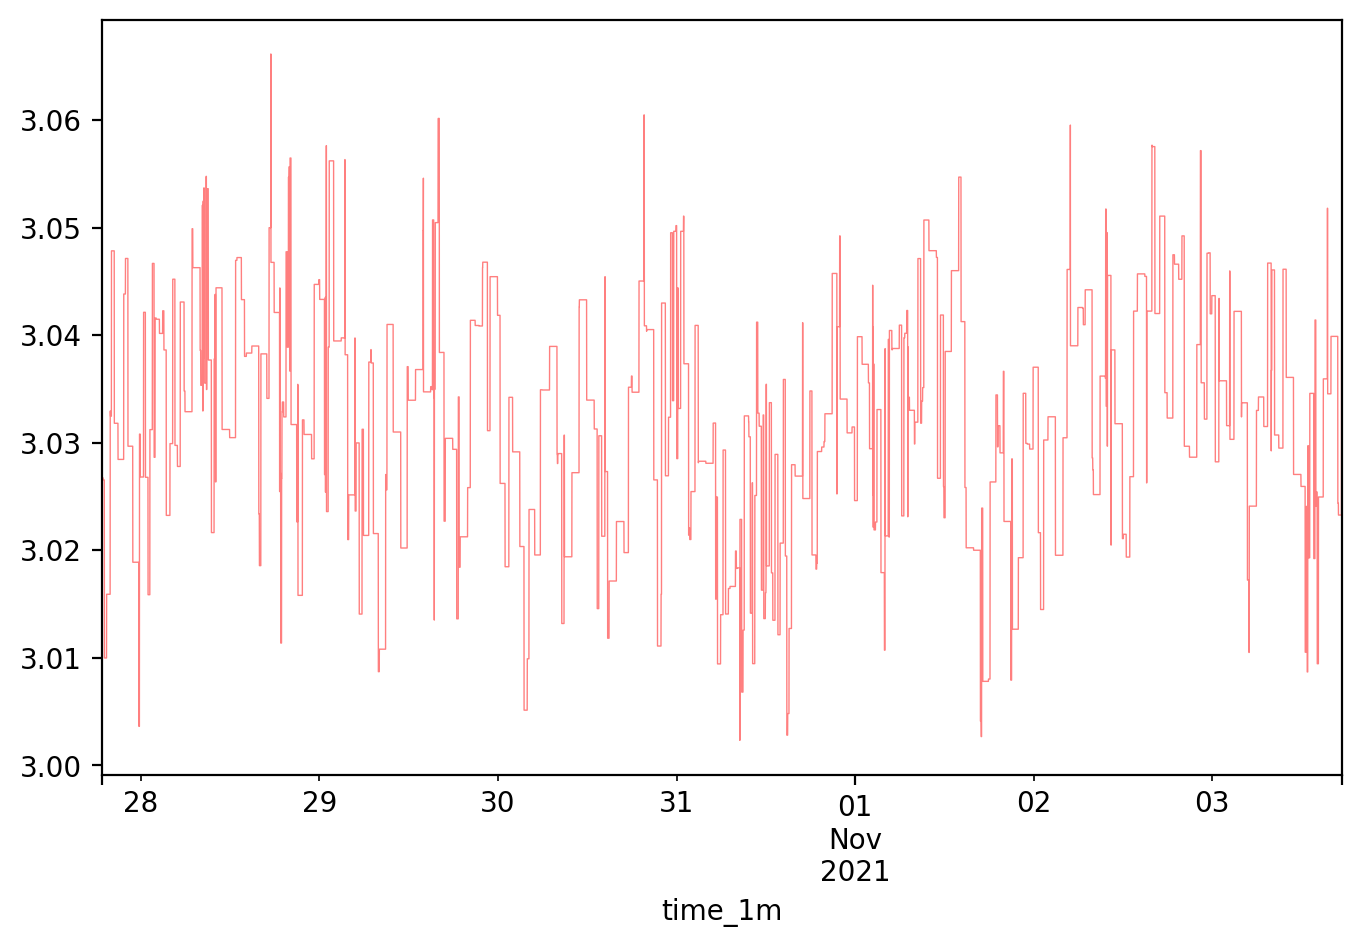

In [60]:
# spot rai/usd
ax = rai_link['rai_usd'][-N_PLOTS:].plot(alpha=0.5, color='red', label='spot', lw=0.5)

# prod twap
#t['twap_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='blue', label='prod twap')

#recreate prod
#t = create_prod_twap(df, 16, 4, 'eth_usd_link')
t = create_prod_twap(df_rai['rai_eth'], df_twap['twap_usd'], df_link['eth_usd_link'], 16, 4, fill=True)

twap_col = 'twap_usd_r'
t[twap_col][-N_PLOTS:].plot(alpha=0.5, color='grey', label=f'recreate prod 16 4', ax=ax, drawstyle='steps-post')

for window_size, period_size in params:
    t = create_prod_twap(df_rai['rai_eth'], df_twap['twap_usd'], df_link['eth_usd_link'], window_size, period_size, fill=True)
    twap_col = 'twap_usd_r'
    t[twap_col][-N_PLOTS:].plot(label=f'{window_size=}, {period_size=}', ax=ax, drawstyle='steps-post')
plt.title('TWAPs')
plt.legend(fontsize=7)
## get real RAI historical params
## plot entire RAI TWAP history, show param changes

## Chainlink RAI/USD Feed

In [ ]:
ax = df_fill['rai_usd_link'][-N_PLOTS:].plot(color='orange', label='CL RAI/USD')

rai_link['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)

rai_link['rai_usd'].rolling('16H').mean()[-N_PLOTS:].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('Chainlink RAI/USD feed vs RAI/USD spot')
plt.legend()

In [ ]:
# Create TWAP directly from RAI/USD
def create_new_twap(df, window_size, period_size, rai_usd_col):
    twap_col = '_'.join(map(str, [rai_usd_col, window_size, period_size]))
    
    df_twap = df.resample(str(period_size) + 'H').first()[[rai_usd_col]]
    
    df_twap[twap_col] = df_twap.rolling(str(window_size) + 'H')[rai_usd_col].mean()
    
    df_twap = df_twap.asfreq('1min', method='ffill').drop(rai_usd_col, axis=1)
    
    df_final = pd.merge(df, df_twap, left_index=True, right_index=True)

    return df_final

In [ ]:
df_direct_cl = create_new_twap(df_fill, 40, 8, 'rai_usd_link')

## TWAP of Chainlink feed vs Prod TWAP

In [ ]:
ax = df_direct_cl['rai_usd_link_40_8'][-N_PLOTS:].plot(color='orange', label='direct TWAP')
rai_link['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
plt.title('TWAP of Chainlink RAI/USD vs Prod TWAP')
plt.legend()

## New TWAP of Chainlink RAI/USD

In [ ]:
rai_link['rai_usd'].head(3)

In [ ]:
ax = df_new_twap['rai_usd'][-N_PLOTS:].plot(color='blue', label='new twap', drawstyle="steps-post")
rai_link['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot', lw=0.5)
plt.legend()